# Post processing the AWAKEN ABL case

In [1]:
%%capture 

# Important libraries header information
# ----------------------------------

# change this directory as necessary
#amrwindfedir = '/home/lcheung/hpc_home/local/Git/amrwind-frontend'   # my version
amrwindfedir = '/projects/wind_uq/lcheung/amrwind-frontend'         # official version
import sys, os
sys.path.insert(1, amrwindfedir)

# Load the libraries
import matplotlib.pyplot as plt
import amrwind_frontend  as amrwind
import numpy             as np
from matplotlib import cm
import re
import time

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

## Postprocess and compare AMR-Wind velocity profiles

In [2]:
 # Set your run directory here
#casedir = '/nscratch/lcheung/2021/SWIFT_Neutral_WS8.7_Alpha0.14/AMRWind_Precursor/precursor1'

caselist = [ 
            #AMR Wind 
            {'rundir':'/gpfs/drhouck/AWAKEN/JRSE_Precursor/newmesh/z0_0p03_newWD', 'tag':'AMR-Wind',
            'mstyle':{'mfc':'b', 'marker':'s', 'lw':0, 'mec':'k',}, 'lstyle':{'color':'b'}},
            # Nalu precursor 
            {'rundir':'/pscratch/mlblayl/AWAKEN/Neutral_Precursor_Yaw/', 'tag':'Nalu-Wind',
            'mstyle':{'mfc':'g', 'marker':'s', 'lw':0, 'mec':'k',}, 'lstyle':{'color':'g','linestyle':'dashed'}},
            #WRF
            {'rundir':'/projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/NeutralABL_turbine1/WRFLES.5kmX5km_turbine1/post_processing/data', 'tag':'WRF-LES',
            'mstyle':{'mfc':'g', 'marker':'s', 'lw':0, 'mec':'k',}, 'lstyle':{'color':'orange','linestyle':'dashdot'}},
           ]

# Average between 15,000 sec to 20,000 sec
avgtimes = [20000, 25000]

# Hub-height locations
#plotheights=[60.0, 91.0]
plotheights=[10.0, 30.0, 60.0, 91.0, 169.0]

# Load the entire netcdf in memory
loadinmemory = False   # Do this only if there's enough RAM and for new (python 3+ netCDF4) libraries

In [3]:
#for AMR-Wind Data
for case in caselist:
    if(case['tag']== 'Nalu-Wind'):
        print("Nalu")
        Nalu_z, Nalu_Temp = np.loadtxt(case['rundir']+'/NaluWind_temperature.dat',  unpack=True)
    if(case['tag']== 'AMR-Wind'):
        print("AMR WInd")
        case['App'] = amrwind.MyApp.init_nogui()
        tstart = time.time()
        case['App'].ABLpostpro_loadnetcdffile(case['rundir']+'/post_processing/abl_statistics40000.nc', usemmap=loadinmemory)
        tend   = time.time()
        print("Load time: %f sec"%(tend-tstart))
    if(case['tag']== 'WRF-LES'):
        print('WRF')
        WRF_z,WRF_WS,WRF_WD,WRF_Th,WRF_TKE,WRF_TI = np.loadtxt(case['rundir']+'/WRFLES_InflowProfiles_noturbine.dat', unpack=True)

AMR WInd
Loading /gpfs/drhouck/AWAKEN/JRSE_Precursor/newmesh/z0_0p03_newWD/post_processing/abl_statistics40000.nc
Time range: 20000.500000 to 25000.000000
Done.
Load time: 12.813209 sec
Nalu
WRF


In [4]:
# First, let's look at the averaged statistics
#for case in caselist:
#    tstart = time.time()
#    case['reportstats'] = case['App'].ABLpostpro_printreport(avgt=avgtimes, avgz=plotheights)
#    tend   = time.time()
#    print("Compute time: %f sec"%(tend-tstart))

## Plot velocity profile

# Compare AMR-Wind temperature profiles

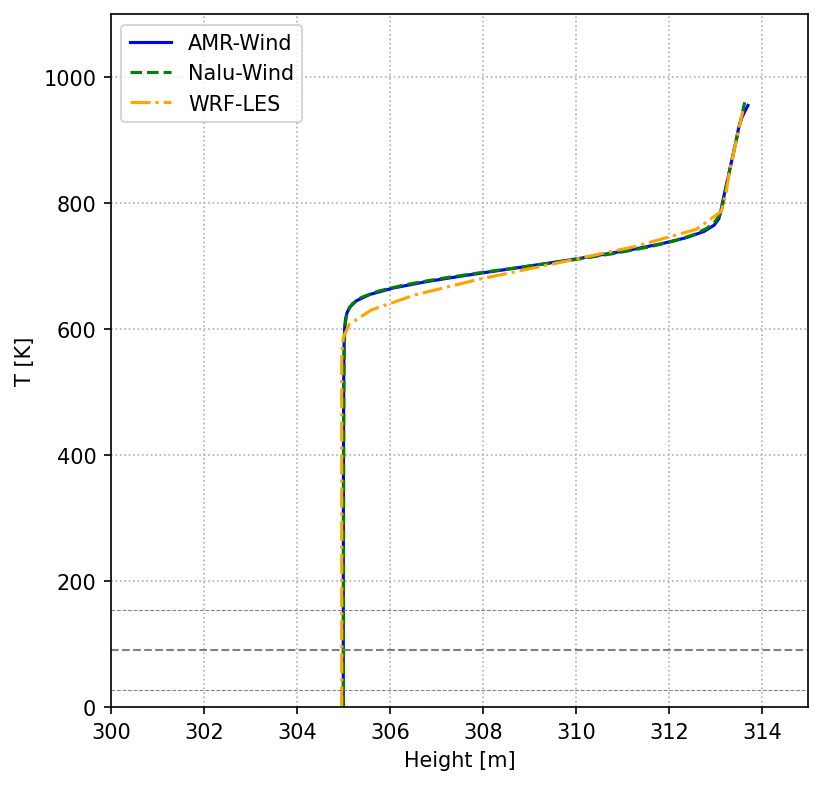

In [7]:
# Plot temperature
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)

# This command returns the data, and then you can plot it individually
for case in caselist:
    if(case['tag']== 'AMR-Wind'): 
        amrdat = case['App'].ABLpostpro_plotprofiles(plotvars=['Temperature'], avgt=avgtimes)
        lstyle=case['lstyle']
        plt.plot(amrdat['T']['data'], amrdat['T']['z'], label=case['tag'], **lstyle)
    if(case['tag']== 'Nalu-Wind'):
        lstyle=case['lstyle']
        plt.plot(Nalu_Temp, Nalu_z, label=case['tag'], **lstyle)
    if(case['tag']== 'WRF-LES'):
        lstyle=case['lstyle']
        plt.plot(WRF_Th, WRF_z, label=case['tag'], **lstyle)

# Plot the turbine dimensions
plt.hlines(90,          300,     315, linestyles='dashed', color='gray', linewidth=1.0) # Plot the HH line
plt.hlines(90+127*0.5,  300,     315, linestyles='dashed', color='gray', linewidth=0.5) # Plot the HH line
plt.hlines(90-127*0.5,  300,     315, linestyles='dashed', color='gray', linewidth=0.5) # Plot the HH line
plt.ylim([0, 1100])
plt.xlim([300, 315])
plt.grid(ls=':')
plt.legend()
plt.ylabel('T [K]')
plt.xlabel('Height [m]')
plt.savefig('Neutra_Temp.png')